# CIFAR-10 dataset on a modified ResNet

In this notebook, we will perform a classification task on the [CIFAR-10 Dataset](https://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy) using a modified version of ResNet. We will freeze the convolutional layers of ResNet, remove the fully connected layer, and add our own configuration of fully connected layer(s). 

Reference: https://keras.io/guides/transfer_learning/ 

In [ ]:
# importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
!pip install scikeras
from scikeras.wrappers import KerasClassifier
import math

# Set the seed value for experiment reproducibility.
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

warnings.simplefilter('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ResNet Model 1

We first load and normalize the CIFAR-10 dataset.

In [ ]:
# load the data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# normalize the data
x_train = (x_train - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)
x_test = (x_test - np.mean(x_test, axis=0)) / np.std(x_test, axis=0)

# take a look at the data
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape, "\n")
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape, "\n")
print("An example of a normalized instance:")
print(x_train[0])
print(f'shape: {x_train[0].shape} \n')
print("An example of a label:")
print(y_train[0])

Shape of training data:
(50000, 32, 32, 3)
(50000, 1) 

Shape of test data:
(10000, 32, 32, 3)
(10000, 1) 

An example of a normalized instance:
[[[-0.97682401 -1.01575822 -0.86457067]
  [-1.20290054 -1.24397271 -1.09116305]
  [-1.12196343 -1.23121589 -1.12774851]
  ...
  [ 0.37226975 -0.05993601 -0.30716213]
  [ 0.29723427 -0.1483418  -0.37591352]
  [ 0.24357708 -0.15787621 -0.36051491]]

 [[-1.5698109  -1.59760997 -1.39387218]
  [-1.79991445 -1.88484817 -1.64744766]
  [-1.56880617 -1.79174252 -1.66185562]
  ...
  [-0.09855519 -0.66409268 -0.96227293]
  [-0.14373515 -0.72217858 -1.01627722]
  [-0.09886808 -0.65922515 -0.92377691]]

 [[-1.45482436 -1.54821175 -1.37961682]
  [-1.58630684 -1.79258968 -1.64550579]
  [-1.14034845 -1.52843453 -1.55931244]
  ...
  [-0.15907907 -0.71348254 -1.01747988]
  [-0.12110123 -0.70263699 -1.00953845]
  [-0.27373108 -0.85187597 -1.1084575 ]]

 ...

 [[ 1.26721816  0.71031234 -0.27672181]
  [ 1.20986321  0.48109763 -1.21174062]
  [ 1.17926178  0.6313301

Now let's build the modified ResNet model. The activation for the added fully connected layer(s) will be ReLU. Optimizer will be ADAM. We will use the default learning rate of ADAM in Keras (0.001) for now.

In [ ]:
class ResNet_mod:

    def __init__(self, n_fclayers=2, n_neurons=[32, 32], activation='relu', learning_rate=0.001, 
                 epochs=20): # n_fclayers does not include the output layer
        self.n_fclayers = n_fclayers
        self.n_neurons = n_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs

    def make_model(self):
        self.base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(32, 32, 3), # shape of CIFAR10 data
            include_top=False)  # Do not include the ImageNet classifier at the top
                                # this is the fully connected layer of ResNet
        
        self.base_model.trainable = False

        # create a new model on top of the base model
        
        inputs = keras.Input(shape=(32, 32, 3))
        # Make sure that the base_model is running in inference mode here by passing `training=False`
        x = self.base_model(inputs, training=False)

        # new
        x = layers.GlobalAveragePooling2D()(x)


        #x = layers.Flatten()(x)


        # add fully connected layer(s)
        for i in range(self.n_fclayers):
            x = keras.layers.Dense(self.n_neurons[i], activation=self.activation)(x)

        outputs = keras.layers.Dense(10)(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
        
        self.model = model

    # def set_trainable(self, status):  # status takes a boolean
    #     self.base_model.trainable = status

    def summary(self):
        self.model.summary()
    
    def train_new_layers(self, x_train, y_train, x_test, y_test):

        earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="auto", patience=10,
                                        restore_best_weights=True)

        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, 
                                 validation_data=(x_test, y_test),
                                 callbacks=[earlystopping])
        
    def train_whole_model(self, x_train, y_train, x_test, y_test):
        # unfreeze all parts and train with a very low learning rate
        self.base_model.trainable = True

        # recompile the model
        self.model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="auto", patience=10,
                                        restore_best_weights=True)

        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, 
                                 validation_data=(x_test, y_test),
                                 callbacks=[earlystopping])
    
    def evaluate(self, x_test, y_test):
        plt.plot(self.history.history['accuracy'], label='training accuracy')
        plt.plot(self.history.history['val_accuracy'], label = 'test accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')

        test_loss, test_acc = self.model.evaluate(x_test,  y_test, verbose=2)

Let's test the model on a small dataset. Let's add only one fully connected layer (besides the output layer). 

In [ ]:
test_model = ResNet_mod()
test_model.make_model()
test_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 23,654,666
Trainable params: 66,954
Non-train

Let's train the new layers of the model.

In [ ]:
test_model.train_new_layers(x_train[:1000], y_train[:1000], x_test[:1000], y_test[:1000])

Epoch 1/20
32/32 [==============================] - 18s 128ms/step - loss: 2.2926 - accuracy: 0.1660 - val_loss: 2.2082 - val_accuracy: 0.1780
Epoch 2/20
32/32 [==============================] - 1s 34ms/step - loss: 2.1617 - accuracy: 0.2070 - val_loss: 2.2204 - val_accuracy: 0.1980
Epoch 3/20
32/32 [==============================] - 2s 53ms/step - loss: 2.1229 - accuracy: 0.2220 - val_loss: 2.1039 - val_accuracy: 0.2590
Epoch 4/20
32/32 [==============================] - 1s 37ms/step - loss: 2.0068 - accuracy: 0.2750 - val_loss: 2.0522 - val_accuracy: 0.2580
Epoch 5/20
32/32 [==============================] - 1s 36ms/step - loss: 1.9189 - accuracy: 0.3020 - val_loss: 2.0383 - val_accuracy: 0.2440
Epoch 6/20
32/32 [==============================] - 1s 33ms/step - loss: 1.8752 - accuracy: 0.3300 - val_loss: 1.9633 - val_accuracy: 0.2910
Epoch 7/20
32/32 [==============================] - 1s 34ms/step - loss: 1.7747 - accuracy: 0.3670 - val_loss: 1.9538 - val_accuracy: 0.3020
Epoch 8/20


32/32 - 0s - loss: 1.9196 - accuracy: 0.3470 - 462ms/epoch - 14ms/step


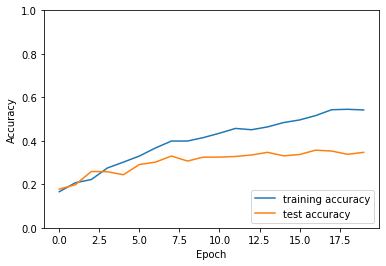

In [ ]:
test_model.evaluate(x_test[:1000], y_test[:1000])

The training and test accuracies are expectedly bad with the small dataset and only 20 training epochs. Let's train the whole model and see if there will be any improvement.

In [ ]:
test_model.train_whole_model(x_train[:1000], y_train[:1000], x_test[:1000], y_test[:1000])

Epoch 1/20
32/32 [==============================] - 50s 158ms/step - loss: 1.6771 - accuracy: 0.4080 - val_loss: 1.9952 - val_accuracy: 0.2890
Epoch 2/20
32/32 [==============================] - 2s 76ms/step - loss: 1.4138 - accuracy: 0.4970 - val_loss: 1.9957 - val_accuracy: 0.3070
Epoch 3/20
32/32 [==============================] - 2s 77ms/step - loss: 1.2570 - accuracy: 0.5450 - val_loss: 1.9806 - val_accuracy: 0.3490
Epoch 4/20
32/32 [==============================] - 2s 76ms/step - loss: 1.1560 - accuracy: 0.5850 - val_loss: 1.9717 - val_accuracy: 0.3520
Epoch 5/20
32/32 [==============================] - 2s 77ms/step - loss: 1.1298 - accuracy: 0.5910 - val_loss: 1.9862 - val_accuracy: 0.3520
Epoch 6/20
32/32 [==============================] - 2s 76ms/step - loss: 1.0156 - accuracy: 0.6450 - val_loss: 1.9886 - val_accuracy: 0.3740
Epoch 7/20
32/32 [==============================] - 2s 62ms/step - loss: 0.9173 - accuracy: 0.6850 - val_loss: 2.1887 - val_accuracy: 0.3640
Epoch 8/20


32/32 - 1s - loss: 2.6272 - accuracy: 0.3800 - 1s/epoch - 32ms/step


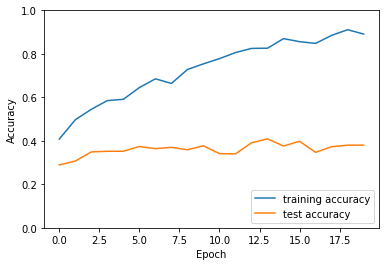

In [ ]:
test_model.evaluate(x_test[:1000], y_test[:1000])

The training accuracy improved a lot. The test accuracy is still low. The model seems to have overfit.

Let's tune the hyperparameters. 

Reference: https://datagraphi.com/blog/post/2019/12/17/how-to-find-the-optimum-number-of-hidden-layers-and-nodes-in-a-neural-network-model 

In [ ]:
# a helper function to decide the number of units in a layer
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    # I am only testing either 1, 2, or 3 hidden layers
    two_exponents = [256, 128, 64, 32, 16]

    if n_layers == 1:
        return [first_layer_nodes]

    if n_layers == 2:
        return [first_layer_nodes, last_layer_nodes]
    
    else:
        first_layer_index = two_exponents.index(first_layer_nodes)
        last_layer_index = two_exponents.index(last_layer_nodes)
        middle_layer_index = math.ceil((first_layer_index + last_layer_index) / 2)
        n_middle_layer = two_exponents[middle_layer_index]
        return [first_layer_nodes, n_middle_layer, last_layer_nodes]

def create_model(n_layers, first_layer_nodes, last_layer_nodes):
    base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(32, 32, 3), # shape of CIFAR10 data
            include_top=False)  # Do not include the ImageNet classifier at the top
                                # this is the fully connected layer of ResNet
        
    base_model.trainable = False

    # create a new model on top of the base model
    
    inputs = keras.Input(shape=(32, 32, 3))
    # Make sure that the base_model is running in inference mode here by passing `training=False`
    x = base_model(inputs, training=False)
    x = layers.Flatten()(x)
    # add fully connected layer(s)
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers+1):
        if i==1:
            x = keras.layers.Dense(first_layer_nodes, input_dim=x_train.shape[1], activation='relu')(x)
        else:
            x = keras.layers.Dense(n_nodes[i-1], activation='relu')(x)

    outputs = keras.layers.Dense(10)(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose = False, n_layers=[1,2,3], 
                        first_layer_nodes=[256,128,64], last_layer_nodes=[256,128,64])  

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(n_layers=[1,2,3], first_layer_nodes=[256,128,64], 
                  last_layer_nodes=[256,128,64], optimizer__learning_rate=learn_rate)
# param_grid = dict(n_layers=n_layers, first_layer_nodes=first_layer_nodes, last_layer_nodes=last_layer_nodes, 
#      optimizer__learning_rate=learn_rate)

# use 3-fold
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# use a smaller dataset to tune because of hardware limitations
grid_result = grid.fit(x_train[:10000], y_train[:10000])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.356899 using {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 2, 'optimizer__learning_rate': 0.1}
nan (nan) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 1, 'optimizer__learning_rate': 0.001}
0.342800 (0.004244) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 1, 'optimizer__learning_rate': 0.01}
0.332501 (0.009473) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 1, 'optimizer__learning_rate': 0.1}
0.325200 (0.006252) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 2, 'optimizer__learning_rate': 0.001}
0.324202 (0.015114) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 2, 'optimizer__learning_rate': 0.01}
0.356899 (0.012421) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 2, 'optimizer__learning_rate': 0.1}
0.323798 (0.014203) with: {'first_layer_nodes': 256, 'last_layer_nodes': 256, 'n_layers': 3, 'optimizer__learning_rate': 0.001}

Based on the result of hyperparameter tuning, we tried using learning rate 0.1 and add two fully connected hidden layers, both with 256 units. It turned out using a learning rate of 0.1 did not converge. This is likely due to the smaller dataset size used while tuning the hyperparameters. Here we will use the default learning rate of the ADAM optimizer in Keras, 0.001.


In [ ]:
model1 = ResNet_mod(n_fclayers=2, n_neurons=[256, 256], activation='relu', learning_rate=0.001, 
                 epochs=200)
model1.make_model()
model1.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                              

In [ ]:
model1.train_new_layers(x_train, y_train, x_test, y_test)

Epoch 1/200
1563/1563 [==============================] - 295s 186ms/step - loss: 1.7429 - accuracy: 0.3742 - val_loss: 1.6335 - val_accuracy: 0.4144
Epoch 2/200
1563/1563 [==============================] - 323s 207ms/step - loss: 1.6012 - accuracy: 0.4285 - val_loss: 1.5807 - val_accuracy: 0.4390
Epoch 3/200
1563/1563 [==============================] - 322s 206ms/step - loss: 1.5416 - accuracy: 0.4535 - val_loss: 1.5375 - val_accuracy: 0.4584
Epoch 4/200
1563/1563 [==============================] - 320s 205ms/step - loss: 1.5055 - accuracy: 0.4649 - val_loss: 1.6076 - val_accuracy: 0.4284
Epoch 5/200
1563/1563 [==============================] - 326s 209ms/step - loss: 1.4760 - accuracy: 0.4784 - val_loss: 1.5124 - val_accuracy: 0.4577
Epoch 6/200
1563/1563 [==============================] - 277s 177ms/step - loss: 1.4502 - accuracy: 0.4846 - val_loss: 1.5075 - val_accuracy: 0.4715
Epoch 7/200
1563/1563 [==============================] - 282s 181ms/step - loss: 1.4182 - accuracy: 0.5000

313/313 - 43s - loss: 1.5237 - accuracy: 0.4847 - 43s/epoch - 138ms/step


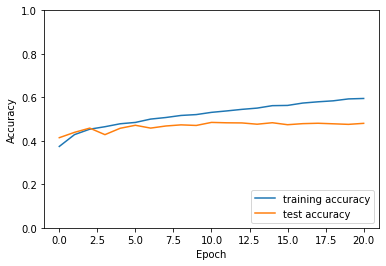

In [ ]:
model1.evaluate(x_test, y_test)

The training and test accuracies are lower than the simple CNN model. We tried to fine-tune the whole model, but each epoch would take more than one hour to train, and fine-tuning requires a very low learning rate (1e-5 as recommended by Keras' tutorial) and more epochs, so our hardware could not handle training the whole model.

## ResNet Model 2

As a result of the poor performance above, here we will build a new model with upsampling, global average pooling, and wider fully-connected layers. In addition, we will use the built-in preprocessing function of ResNet50 to preprocess the data.

Reference: https://www.kaggle.com/code/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_train = keras.applications.resnet50.preprocess_input(x_train)
x_test = x_test.astype('float32')
x_test = keras.applications.resnet50.preprocess_input(x_test)

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# take a look at the data
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape, "\n")
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape, "\n")
print("An example of an instance:")
print(x_train[0])
print(f'shape: {x_train[0].shape} \n')
print("An example of a label:")
print(y_train[0])

Shape of training data:
(50000, 32, 32, 3)
(50000, 1) 

Shape of test data:
(10000, 32, 32, 3)
(10000, 1) 

An example of an instance:
[[[ -40.939003   -54.779      -64.68     ]
  [ -58.939003   -70.779      -80.68     ]
  [ -60.939003   -68.779      -73.68     ]
  ...
  [   4.060997    15.221001    34.32     ]
  [  -1.939003     8.221001    28.32     ]
  [  -0.939003     7.2210007   24.32     ]]

 [[ -83.939      -96.779     -107.68     ]
  [-103.939     -116.779     -123.68     ]
  [-103.939     -108.779     -105.68     ]
  ...
  [ -48.939003   -28.779       -0.6800003]
  [ -53.939003   -33.779       -4.6800003]
  [ -46.939003   -29.779       -1.6800003]]

 [[ -82.939      -92.779      -98.68     ]
  [-103.939     -109.779     -107.68     ]
  [ -95.939      -89.779      -74.68     ]
  ...
  [ -53.939003   -32.779       -5.6800003]
  [ -53.939003   -32.779       -3.6800003]
  [ -61.939003   -43.779      -14.68     ]]

 ...

 [[  -7.939003    53.221       84.32     ]
  [ -69.939       

In [ ]:
class ResNet_mod2:

    def __init__(self, n_fclayers=2, n_neurons=[1024, 512], activation='relu', 
                 learning_rate=0.001, epochs=200, batch_size=64, patience=10): 
                 # n_fclayers does not include the output layer
        self.n_fclayers = n_fclayers
        self.n_neurons = n_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = 64
        self.patience = patience

    def make_model(self):
        self.base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(224, 224, 3), # shape of CIFAR10 data
            include_top=False)  # Do not include the ImageNet classifier at the top
                                # this is the fully connected layer of ResNet
        
        self.base_model.trainable = False

        # create a new model on top of the base model
        
        inputs = keras.layers.Input(shape=(32,32,3))

        # upsampling
        resize = keras.layers.UpSampling2D(size=(7,7))(inputs)
        x = self.base_model(resize, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Flatten()(x)

        for i in range(self.n_fclayers):
            x = keras.layers.Dense(self.n_neurons[i], activation=self.activation)(x)

        outputs = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

        model = keras.Model(inputs, outputs)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
        
        self.model = model

    def summary(self):
        self.model.summary()
    
    def train_new_layers(self, x_train, y_train, x_test, y_test):

        earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="auto", patience=self.patience,
                                        restore_best_weights=True)

        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, 
                                 validation_data=(x_test, y_test),
                                 callbacks=[earlystopping], batch_size=self.batch_size)
        
    def train_whole_model(self, x_train, y_train, x_test, y_test):
        # unfreeze all parts and train with a very low learning rate
        self.base_model.trainable = True

        # recompile the model
        self.model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="auto", patience=10,
                                        restore_best_weights=True)

        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, 
                                 validation_data=(x_test, y_test),
                                 callbacks=[earlystopping], batch_size=self.batch_size)
    
    def evaluate(self, x_test, y_test):
        plt.plot(self.history.history['accuracy'], label='training accuracy')
        plt.plot(self.history.history['val_accuracy'], label = 'test accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')

        test_loss, test_acc = self.model.evaluate(x_test,  y_test, verbose=2)

Let's first experiment with the two dense layers having 512 and 256 units each.

In [ ]:
model2 = ResNet_mod2(n_neurons=[512, 256], epochs=50)
model2.make_model()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049

In [ ]:
model2.train_new_layers(x_train, y_train, x_test, y_test)

Epoch 1/50
782/782 [==============================] - 196s 245ms/step - loss: 0.7002 - accuracy: 0.7538 - val_loss: 0.5757 - val_accuracy: 0.8006
Epoch 2/50
782/782 [==============================] - 193s 247ms/step - loss: 0.5151 - accuracy: 0.8207 - val_loss: 0.5658 - val_accuracy: 0.8061
Epoch 3/50
782/782 [==============================] - 182s 232ms/step - loss: 0.4414 - accuracy: 0.8443 - val_loss: 0.5346 - val_accuracy: 0.8130
Epoch 4/50
782/782 [==============================] - 192s 246ms/step - loss: 0.3909 - accuracy: 0.8609 - val_loss: 0.5167 - val_accuracy: 0.8241
Epoch 5/50
782/782 [==============================] - 193s 246ms/step - loss: 0.3469 - accuracy: 0.8764 - val_loss: 0.4907 - val_accuracy: 0.8372
Epoch 6/50
782/782 [==============================] - 193s 246ms/step - loss: 0.3138 - accuracy: 0.8884 - val_loss: 0.5200 - val_accuracy: 0.8311
Epoch 7/50
782/782 [==============================] - 192s 246ms/step - loss: 0.2806 - accuracy: 0.8980 - val_loss: 0.5581 -

313/313 - 32s - loss: 0.4907 - accuracy: 0.8372 - 32s/epoch - 101ms/step


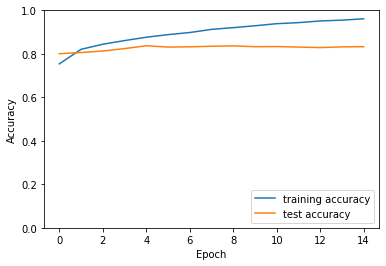

In [ ]:
model2.evaluate(x_test, y_test)

The test accuracy is 0.8372, a big improvement. Let's see if we can further improve it.

In [ ]:
model3 = ResNet_mod2(n_neurons=[512, 512], epochs=50, patience=5)
model3.make_model()
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049

In [ ]:
model3.train_new_layers(x_train, y_train, x_test, y_test)

Epoch 1/50
782/782 [==============================] - 195s 245ms/step - loss: 0.6978 - accuracy: 0.7556 - val_loss: 0.5706 - val_accuracy: 0.8008
Epoch 2/50
782/782 [==============================] - 181s 232ms/step - loss: 0.5153 - accuracy: 0.8206 - val_loss: 0.5929 - val_accuracy: 0.8017
Epoch 3/50
782/782 [==============================] - 181s 232ms/step - loss: 0.4462 - accuracy: 0.8436 - val_loss: 0.5189 - val_accuracy: 0.8172
Epoch 4/50
782/782 [==============================] - 192s 246ms/step - loss: 0.3910 - accuracy: 0.8611 - val_loss: 0.5246 - val_accuracy: 0.8233
Epoch 5/50
782/782 [==============================] - 181s 231ms/step - loss: 0.3511 - accuracy: 0.8752 - val_loss: 0.5034 - val_accuracy: 0.8321
Epoch 6/50
782/782 [==============================] - 181s 231ms/step - loss: 0.3192 - accuracy: 0.8849 - val_loss: 0.5055 - val_accuracy: 0.8318
Epoch 7/50
782/782 [==============================] - 192s 246ms/step - loss: 0.2789 - accuracy: 0.9001 - val_loss: 0.5544 -

313/313 - 31s - loss: 0.5361 - accuracy: 0.8375 - 31s/epoch - 99ms/step


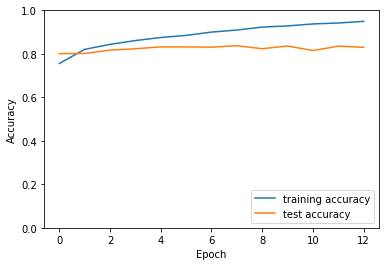

In [ ]:
model3.evaluate(x_test, y_test)

The result is similar to the previous model's. Let's try an even wider dense layer. 

In [ ]:
model4 = ResNet_mod2(n_neurons=[1024, 512], epochs=50, patience=5)
model4.make_model()
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              2098

In [ ]:
model4.train_new_layers(x_train, y_train, x_test, y_test)

Epoch 1/50
782/782 [==============================] - 180s 225ms/step - loss: 0.7185 - accuracy: 0.7508 - val_loss: 0.5814 - val_accuracy: 0.7987
Epoch 2/50
782/782 [==============================] - 192s 245ms/step - loss: 0.5149 - accuracy: 0.8207 - val_loss: 0.5795 - val_accuracy: 0.8058
Epoch 3/50
782/782 [==============================] - 181s 232ms/step - loss: 0.4430 - accuracy: 0.8444 - val_loss: 0.5015 - val_accuracy: 0.8260
Epoch 4/50
782/782 [==============================] - 192s 245ms/step - loss: 0.3895 - accuracy: 0.8614 - val_loss: 0.5240 - val_accuracy: 0.8221
Epoch 5/50
782/782 [==============================] - 193s 246ms/step - loss: 0.3462 - accuracy: 0.8772 - val_loss: 0.5317 - val_accuracy: 0.8272
Epoch 6/50
782/782 [==============================] - 192s 246ms/step - loss: 0.3140 - accuracy: 0.8877 - val_loss: 0.4954 - val_accuracy: 0.8357
Epoch 7/50
782/782 [==============================] - 192s 246ms/step - loss: 0.2746 - accuracy: 0.9018 - val_loss: 0.5227 -

313/313 - 27s - loss: 0.5227 - accuracy: 0.8384 - 27s/epoch - 87ms/step


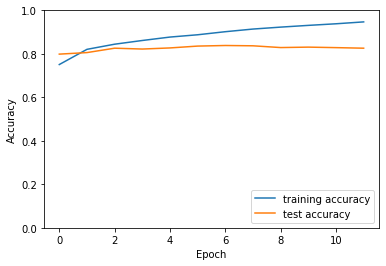

In [ ]:
model4.evaluate(x_test, y_test)

The performance improved slightly, achieveing 83.84% test accuracy.